In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Code du TP

In [39]:
class Wline():

    def __init__(self, size=None, policy=(lambda x: 0)):
        self.size = size
        self.next = policy
        
    def populate(self, queue):
        self.queue = queue
    
    def pop(self):
        pop_ix = self.next(self.queue)
        pop_val = None
        
        if -1 < pop_ix < len(self.queue):
            pop_val = self.queue[pop_ix]
            self.queue.pop(pop_ix)
            
        return pop_val

In [40]:
class InService():
    
    def __init__(self, nb=1, dist=None):
        self.nb = nb
        self.server = [None]*nb
        self.dist = dist
        
    def full(self):
        return not (None in self.server)
        
    def leaving(self, tops):
        
        agent_id = None
        
        if not self.full():
            #Extract index of an available server
            srv_ix = self.server.index(None) 
        
        else:
            #Find agent of smallest departure time, needs to be float to use idxmin
            agent_id = tops.loc[self.server, 't_depart_sys'].astype(float).idxmin()
            #Extract server number of departing agent
            srv_ix = self.server.index(agent_id) 
        
        return srv_ix, agent_id

In [47]:
class QS():
    
    def __init__(self, arval_dist, srv_dist, servers_nb, 
                 queue_size=None, policy=lambda x:0, test_size=100) :
         
        #Initializing metadata
        self.arval_dist = arval_dist
        self.srv_dist = srv_dist
        self.srv_z = servers_nb
        self.queue_z = queue_size if queue_size else test_size
        self.test_z = test_size

        #Initializing Waiting Line
        self.wline = Wline(size=queue_size, policy=policy)
        
        #Initializing In Service List
        self.inservice = InService(nb=servers_nb, dist=srv_dist)
        
        #Initializin tops dataframe
        column_names = ['t_arval_queue', 't_arval_srv', 't_depart_sys']
        self.tops = pd.DataFrame(np.empty((test_size, 3),dtype=object), columns=column_names)
        
    def pretreat(self):
        
        #Easing naming
        tops = self.tops

        t_interarvals = self.arval_dist(size=(self.test_z))
        tops.loc[0, 't_arval_queue'] = t_interarvals[0]
                
        for agent in range(1, self.test_z) :
            tops.loc[agent, 't_arval_queue'] = tops.loc[agent - 1, 't_arval_queue'] + t_interarvals[agent]
        
    def run(self):
        
        #Easing naming
        wline = self.wline
        inservice = self.insevice
        tops = self.tops
        
        #Initializing arrival queue
        wline.queue = list(tops.loc[0:0].index)
        #Initializing upcomgin theoretical arrival        
        buffer_ix = 1 
    
        while buffer_ix < self.test_z:
            
            _next = wline.pop()
            if _next is not None: #Waiting line is not empty 

                #Update server arrival time as if no waiting was needed
                tops.loc[_next, 't_arval_srv'] = tops.loc[_next, 't_arval_queue']
                
                #Find next available server
                srv_ix, dept_ag = inservice.leaving(tops)
    
                #Fill available server with corresponding next agent in waiting line
                inservice.server[srv_ix] = _next 
                    
                if dept_ag is not None :
                    if tops.loc[_next, 't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys'] : 
                        #Update server arrival time in case arrival is before system departure
                        tops.loc[_next, 't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']
                        
                #Update system departure time
                tops.loc[_next, 't_depart_sys'] = tops.loc[_next, 't_arval_srv'] + inservice.dist() 
                                            
            #Counting prior agents still in system
            in_system = (tops.loc[0:buffer_ix - 1, 't_depart_sys'] > tops.loc[buffer_ix, 't_arval_queue']).sum()
                            
            if self.queue_z is not None and in_system >= self.queue_z + self.inservice.nb:
                tops.loc[buffer_ix, 't_depart_sys'] = -1
            else:
                wline.queue.append(buffer_ix)
                    
            buffer_ix += 1
                
    def posttreat(self):
        
        #Easing naming
        tops = self.tops
        
        tops['t_sojourn'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_queue'])
        tops['t_waiting'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_arval_srv'] - tops['t_arval_queue'])
        tops['t_service'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_srv'])
        tops['blocked'] = tops.loc[:,'t_depart_sys'] == -1
        tops['waited'] = tops['t_waiting'] > 0 
    
    def timeline(self, t_delation=2):
        
        #Easing naming
        tops = self.tops
        test_z = self.test_z

        # Process determination
        colnames = ['ag_in_sys', 'ag_in_queue', 'ag_in_service']
        t_range = np.linspace(0., tops['t_depart_sys'].max(), t_delation*test_z)
        process = pd.DataFrame(np.empty((t_range.shape[0], 3),dtype=object), 
                                index=t_range, columns=colnames)
        
        for t in process.index:
            process.loc[t, 'ag_in_sys'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_depart_sys'])).sum()
            process.loc[t, 'ag_in_queue'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_arval_srv'])).sum()
            process.loc[t, 'ag_in_service'] = ((t > tops['t_arval_srv']) & (t <= tops['t_depart_sys'])).sum()
        
        # Statistics extractions
        statnames = ['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 
                     'waiting_proportion', 'blocked_proportion', 'servers_max_usage']
        stats = pd.DataFrame(np.empty((len(statnames), 1),dtype=object), index=statnames, columns=['run value'])
 
        stats.loc['mean_sojourn_time'] = tops['t_sojourn'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_waiting_time'] = tops['t_waiting'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_service_time'] = tops['t_service'].sum() / (~tops['blocked']).sum()

        stats.loc['waiting_proportion'] = tops['waited'].sum() / (~tops['blocked']).sum()
        stats.loc['blocked_proportion'] = tops['blocked'].sum() / test_z

        # An approximation of server usage, for better approximation raise t_delation.
        stats.loc['servers_max_usage'] = (process['ag_in_service'] == self.inservice.nb).sum() / (t_delation*test_z - 1)

        return process, stats

In [68]:
class Waterfall:

    def __init__(self, lambda_a, lambda_t, lambda_d, nb_servers_test, nb_servers_front=1, q_test_size=None, q_front_size=None, size=100):

        rng = np.random.default_rng(seed=42)

        self.lambda_a = lambda_a
        self.lambda_t = lambda_t
        self.lambda_d = lambda_d

        self.nb_servers_test = nb_servers_test
        self.nb_servers_front = nb_servers_front

        self.a_dist = lambda size : rng.exponential(1./lambda_a, size=size)
        self.t_dist = lambda : rng.exponential(1./lambda_t)
        self.d_dist = lambda : rng.exponential(1./lambda_d)

        self.q_test_size = q_test_size
        self.q_front_size = q_front_size

        self.test_z = size

        self.q_test = QS(self.a_dist, self.t_dist, nb_servers_test, q_test_size, policy = lambda x: 0, test_size=size)
        self.q_front = QS(self.t_dist, self.d_dist, nb_servers_front, q_front_size, policy = lambda x: 0, test_size=size)

        pass

    def run(self):
        
        # Pretreat to generate arrivals
        self.q_test.pretreat()

        # Simule la file de tests
        self.q_test.run()

        # Transfert des départs du système de test comme arrivées pour le front
        valid_departures = self.q_test.tops[self.q_test.tops['t_depart_sys'] != -1]
        self.q_front.tops.loc[:, 't_arval_queue'] = valid_departures['t_depart_sys'].values

        # Simule la file de front
        self.q_front.run()

        pass

    def posttreat(self):
        """
        Calcule les statistiques pour les deux systèmes de files d'attente.
        """
        # Post-traitement des deux queues
        self.q_test.posttreat()
        self.q_front.posttreat()

        # Statistiques combinées
        combined_stats = {
            'Test Queue': self.q_test.timeline()[1],
            'Front Queue': self.q_front.timeline()[1]
        }

        return combined_stats
    

    def timeline(self, t_delation=2):
        """
        Retourne les processus et les statistiques pour chaque queue.
        """
        process_test, stats_test = self.q_test.timeline(t_delation)
        process_front, stats_front = self.q_front.timeline(t_delation)

        return {
            'Test Process': process_test,
            'Front Process': process_front,
            'Test Stats': stats_test,
            'Front Stats': stats_front
        }


In [69]:
# === Lambda parameters ===

tags_mean_dist = 5 # mean distance between incoming tags, in seconds
lambda_a = 1. / tags_mean_dist

k_test = 2 # number of servers in the test queue, i.e. number of tags that can be tested simultaneously
test_mean_dist = 10 # mean treatment time for a tag, in seconds (duration of the testsuite)
mu_t = 1. / test_mean_dist
lambda_t = mu_t * k_test

k_front = 1 # always 1 server
mu_d = 1. # mean time to transfer the result of a tag to the front of the user, in seconds
lambda_d = mu_d * k_front

# === Queue sizes === 
q_test_size = None # infinite
q_front_size = None # infinite

waterfall = Waterfall(
    lambda_a=lambda_a,
    lambda_t=lambda_t,
    lambda_d=lambda_d,
    nb_servers_test=k_test,
    nb_servers_front=k_front,
    q_test_size=q_front_size,
    q_front_size=q_front_size,
    size=100
)

In [70]:
waterfall.run()

waterfall_stats = waterfall.posttreat()

In [71]:
waterfall_stats

{'Test Queue':                    run value
 mean_sojourn_time   6.679029
 mean_waiting_time   1.636487
 mean_service_time   5.042542
 waiting_proportion      0.43
 blocked_proportion       0.0
 servers_max_usage   0.386935,
 'Front Queue':                    run value
 mean_sojourn_time   3.975519
 mean_waiting_time   3.028466
 mean_service_time   0.947053
 waiting_proportion      0.47
 blocked_proportion       0.0
 servers_max_usage   0.231156}

In [72]:
timeline = waterfall.timeline()

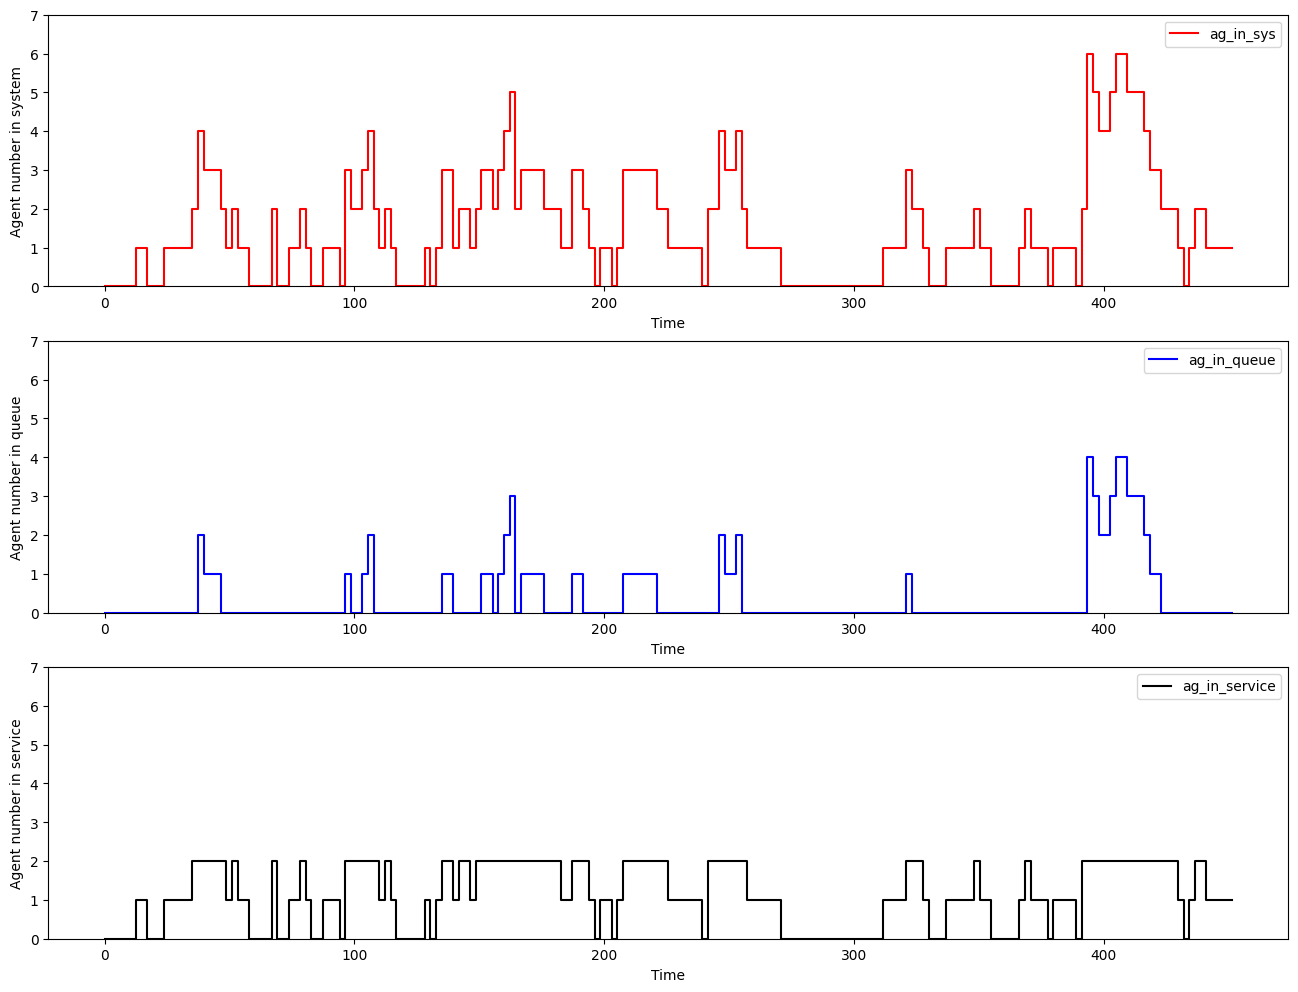

In [73]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    timeline['Test Process'].plot(y= counts[i], 
                   use_index=True, ax=axes[i], linewidth=1.5,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(timeline['Test Process']['ag_in_sys']+1)])

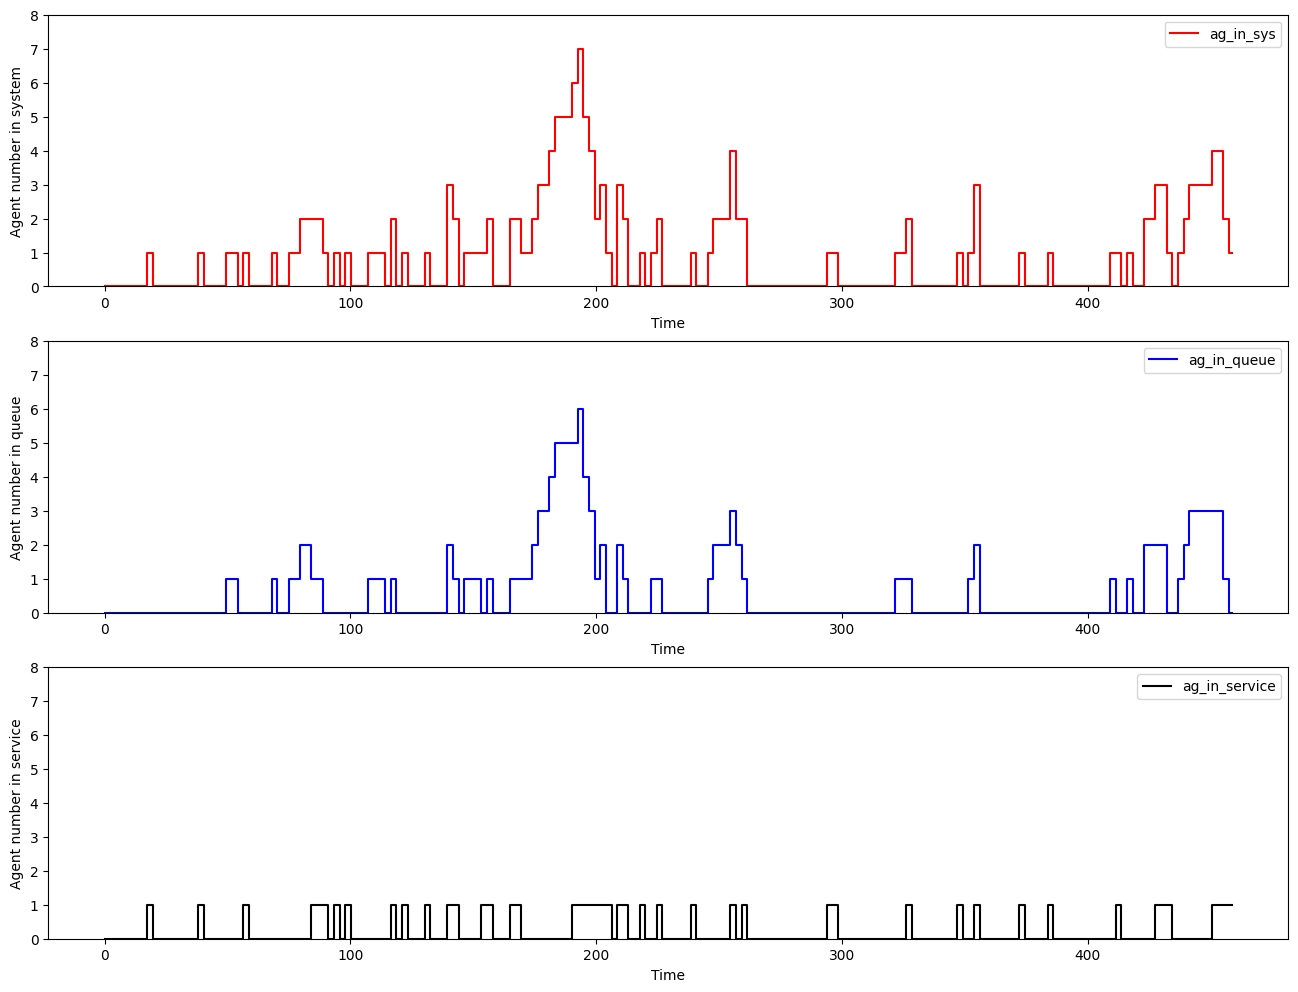

In [61]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    timeline['Front Process'].plot(y= counts[i], 
                   use_index=True, ax=axes[i], linewidth=1.5,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(timeline['Front Process']['ag_in_sys']+1)])